In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import QuantileTransformer

import statsmodels.formula.api as smf

from sklearn.ensemble import GradientBoostingRegressor

In [2]:
training_file = 'training.csv'
train_df = pd.read_csv(training_file)

In [158]:
train_df.head()

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak,LogInducedVertBreak
0,0,95.33,2893.0,10.68,21.33,3.337903
1,0,94.41,2038.0,17.13,5.77,2.533697
2,0,90.48,2183.0,6.61,15.39,3.100993
3,0,93.04,2279.0,9.33,14.57,3.063391
4,0,95.17,2384.0,6.99,17.62,3.196630


In [4]:
train_df.isnull().sum()

InPlay              0
Velo                0
SpinRate            6
HorzBreak           0
InducedVertBreak    0
dtype: int64

In [5]:
train_df['SpinRate'] = train_df['SpinRate'].fillna(train_df['SpinRate'].median())

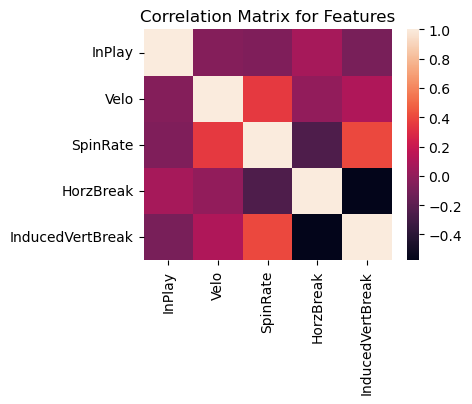

In [6]:
corr_matrix = train_df.corr()

fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(corr_matrix)

plt.title("Correlation Matrix for Features")
plt.show()

In [7]:
corr_matrix

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
InPlay,1.000000,-0.052358,-0.065980,0.072869,-0.093320
Velo,-0.052358,1.000000,0.350879,0.001000,0.105463
SpinRate,-0.065980,0.350879,1.000000,-0.253720,0.398813
HorzBreak,0.072869,0.001000,-0.253720,1.000000,-0.577016
InducedVertBreak,-0.093320,0.105463,0.398813,-0.577016,1.000000


In [8]:
def plot_spinrate(feature=None):
    
    fig, ax = plt.subplots(figsize=(4,3))

    sns.scatterplot(x='SpinRate', y=f'{feature}', data=train_df, hue='InPlay')
    plt.title(f"{feature} versus SpinRate")
    plt.show()

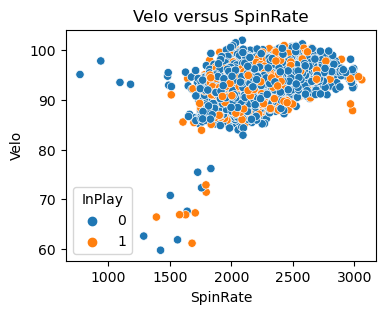

In [9]:
plot_spinrate('Velo')

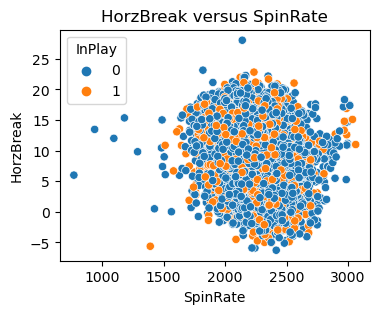

In [10]:
plot_spinrate('HorzBreak')

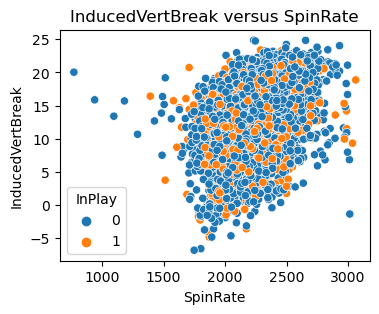

In [11]:
plot_spinrate('InducedVertBreak')

In [12]:
# maybe we should get rid of those observations

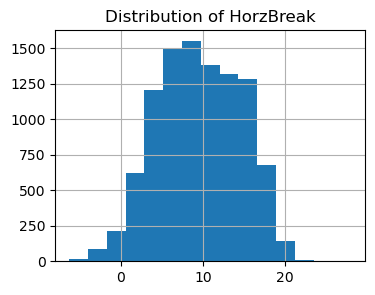

In [13]:
fig, ax = plt.subplots(figsize=(4,3))

train_df['HorzBreak'].hist(bins=15)

plt.title("Distribution of HorzBreak")
plt.show()

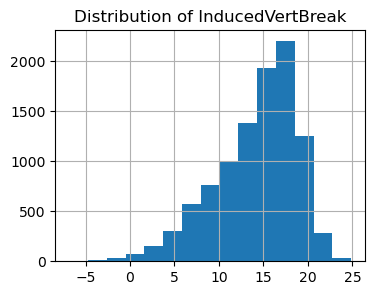

In [14]:
fig, ax = plt.subplots(figsize=(4,3))

train_df['InducedVertBreak'].hist(bins=15)

plt.title("Distribution of InducedVertBreak")
plt.show()

In [15]:
# what's the smallest value in the InducedVertBreak column?

constant = abs(train_df['InducedVertBreak'].min())

# adding an epsilon to avoid the zero
new_break = train_df['InducedVertBreak'] + constant + 0.01

# addinga column of log transformed inducedvertbreak
train_df['LogInducedVertBreak'] = np.log(new_break)

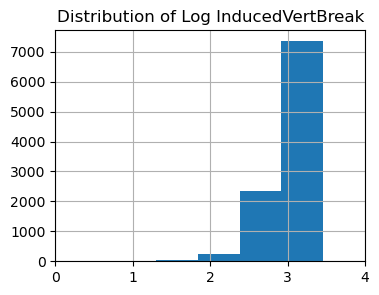

In [16]:
fig, ax = plt.subplots(figsize=(4,3))

train_df['LogInducedVertBreak'].hist(bins=15)

plt.title("Distribution of Log InducedVertBreak")
plt.xlim([0, 4])
plt.show()

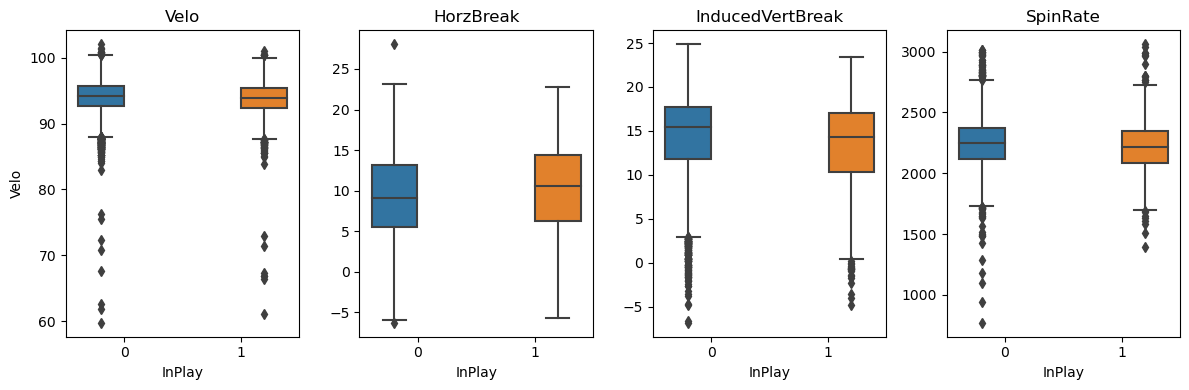

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

sns.boxplot(x='InPlay', y='Velo', data=train_df, hue='InPlay', ax=axes[0])
axes[0].set_title('Velo')
axes[0].legend().remove()

sns.boxplot(x='InPlay', y='HorzBreak', data=train_df, hue='InPlay', ax=axes[1])
axes[1].set_title('HorzBreak')
axes[1].set_ylabel('')
axes[1].legend().remove()

sns.boxplot(x='InPlay', y='InducedVertBreak', data=train_df, hue='InPlay', ax=axes[2])
axes[2].set_title('InducedVertBreak')
axes[2].set_ylabel('')
axes[2].legend().remove()

sns.boxplot(x='InPlay', y='SpinRate', data=train_df, hue='InPlay', ax=axes[3])
axes[3].set_title('SpinRate')
axes[3].set_ylabel('')
axes[3].legend().remove()

plt.tight_layout()
plt.show()

In [27]:
from scipy.stats import kstest

for col in train_df.columns:
    dist_0 = train_df[train_df['InPlay'] == 0][col].values
    dist_1 = train_df[train_df['InPlay'] == 1][col].values
    tstat, pval = kstest(dist_0, dist_1)
    print(col, tstat, round(pval, 4))

InPlay 1.0 0.0
Velo 0.05097081748548394 0.0001
SpinRate 0.06684015306112909 0.0
HorzBreak 0.09757280594197133 0.0
InducedVertBreak 0.09684761569829176 0.0
LogInducedVertBreak 0.09684761569829176 0.0


# Logistic Regression Models  

We'll start with a model that includes SpinRate

In [18]:
import statsmodels.formula.api as smf


smf_model = smf.logit('InPlay ~ standardize(Velo) + standardize(HorzBreak) + standardize(SpinRate) + \
                       standardize(InducedVertBreak) + I(standardize(InducedVertBreak)**2)',
                      data=train_df)

result = smf_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.578334
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 InPlay   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            5
Date:                Sat, 02 Sep 2023   Pseudo R-squ.:                 0.01130
Time:                        13:15:26   Log-Likelihood:                -5783.3
converged:                       True   LL-Null:                       -5849.4
Covariance Type:            nonrobust   LLR p-value:                 8.222e-27
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.9255      0.028    -32.934      0.000      -0.981      -0.870
standardize(Velo)                        -0.0890      0.024     -3.758      0.000      -0.135      -0.043
standardize(HorzBreak)                    0.0618      0.028      2.220      0.026       0.007       0.116
standardize(SpinRate)                    -0.0315      0.026     -1.191      0.233      -0.083       0.020
standardize(InducedVertBreak)            -0.2180      0.034     -6.318      0.000      -0.286      -0.150
I(standardize(InducedVertBreak) ** 2)    -0.0761      0.018     -4.293      0.000      -0.111      -0.041
=========================================================================================================
"""

 the p-value of spin rate is not significant. this isn't too surprising  
 because the other properties of the pitch will depend on the spin rate.    
 
 spinrate is  not a 'confounder' because it won't, on its own,  
 affect the outcome of a swing except through the other variables.  
 including it in the regression constraints their variance  
 and will lead to an understimate of their effect on InPlay.
 
 now we'll build a model without it.  

In [31]:
nospin_model = smf.logit('InPlay ~ standardize(Velo) + standardize(HorzBreak) + \
                       standardize(InducedVertBreak) + I(standardize(InducedVertBreak)**2)',
                      data=train_df)

nospin_result = nospin_model.fit()
nospin_result.summary()

Optimization terminated successfully.
         Current function value: 0.578405
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 InPlay   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Sat, 02 Sep 2023   Pseudo R-squ.:                 0.01118
Time:                        15:19:31   Log-Likelihood:                -5784.0
converged:                       True   LL-Null:                       -5849.4
Covariance Type:            nonrobust   LLR p-value:                 2.686e-27
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.9229      0.028    -32.940      0.000      -0.978      -0.868
standardize(Velo)                        -0.0990      0.022     -4.468      0.000      -0.142      -0.056
standardize(HorzBreak)                    0.0637      0.028      2.296      0.022       0.009       0.118
standardize(InducedVertBreak)            -0.2301      0.033     -6.994      0.000      -0.295      -0.166
I(standardize(InducedVertBreak) ** 2)    -0.0784      0.018     -4.448      0.000      -0.113      -0.044
=========================================================================================================
"""

For the sake of comparison, I'm going to build a model that uses a log  
transformation of the InducedVertBreak to see how it compares.  

In [33]:
nospin_log_model = smf.logit('InPlay ~ standardize(Velo) + standardize(HorzBreak) + \
                       standardize(LogInducedVertBreak) + I(standardize(LogInducedVertBreak)**2)',
                      data=train_df)

nospin_log_model = nospin_log_model.fit()
nospin_log_model.summary()

Optimization terminated successfully.
         Current function value: 0.578851
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 InPlay   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Sat, 02 Sep 2023   Pseudo R-squ.:                 0.01041
Time:                        15:20:18   Log-Likelihood:                -5788.5
converged:                       True   LL-Null:                       -5849.4
Covariance Type:            nonrobust   LLR p-value:                 2.181e-25
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -0.9451      0.025    -37.144      0.000      -0.995      -0.895
standardize(Velo)                           -0.0979      0.022     -4.423      0.000      -0.141      -0.055
standardize(HorzBreak)                       0.0649      0.028      2.328      0.020       0.010       0.119
standardize(LogInducedVertBreak)            -0.2484      0.039     -6.300      0.000      -0.326      -0.171
I(standardize(LogInducedVertBreak) ** 2)    -0.0589      0.014     -4.240      0.000      -0.086      -0.032
============================================================================================================
"""

# How does each variable affect InPlay Probability?  

The predictive performance of the model without spin or a log transform  
is so far best, so i'll plot the probabilities of how it affects the  
outcome.  

In [34]:
def convert_logodds_to_prob(log_odds):
    return np.exp(log_odds) / (1 + np.exp(log_odds))

def compute_prob(intercept, coefficients, predictors):
    log_odds = intercept + np.dot(coefficients, predictors)
    return convert_logodds_to_prob(log_odds)

In [35]:
# defining the intercept and coefficients - the most likely ones
intercept = -0.9451
coefficients = [-0.0979, 0.0649, -0.2484, -0.0589]

# defining a range of zscores to iterate through
z_score_range = np.linspace(-2, 2, 25)

# lists to hold the output probabilities - we'll plot them below
velo_prob = []
horzbreak_prob = []
induced_vert_prob = []

# the loop to do so
for n in z_score_range:
    # velocity with all other variables 0
    predictors_velocity = [n, 0, 0, 0]
    # horzbreak, same
    predictors_horzbreak = [0, n, 0, 0]
    # induced, same - note two entries
    predictors_induced = [0, 0, n, n ** 2]
    
    # computed probability using functions above
    prob_velocity = compute_prob(intercept, coefficients, predictors_velocity)
    prob_horz = compute_prob(intercept, coefficients, predictors_horzbreak)
    prob_induced = compute_prob(intercept, coefficients, predictors_induced)
    
    # appending to the lists
    velo_prob.append(prob_velocity)
    horzbreak_prob.append(prob_horz)
    induced_vert_prob.append(prob_induced)

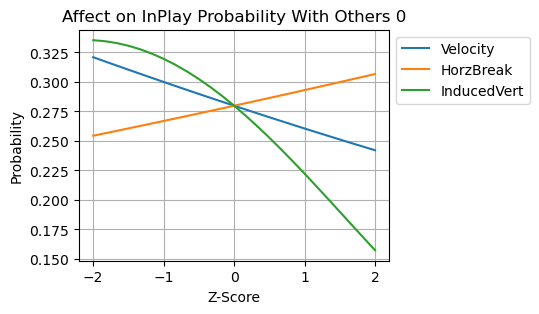

In [37]:
fig, ax = plt.subplots(figsize=(4,3))

plt.plot(z_score_range, velo_prob, label='Velocity')
plt.plot(z_score_range, horzbreak_prob, label='HorzBreak')
plt.plot(z_score_range, induced_vert_prob, label='InducedVert')

plt.ylabel("Probability")
plt.xlabel("Z-Score")
plt.title("Affect on InPlay Probability With Others 0")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [38]:
# what do these zscores mean?

train_df[['Velo', 'HorzBreak', 'InducedVertBreak']].agg(['mean', 'std']).T

,mean,std
Velo,93.957429,2.683740
HorzBreak,9.549388,5.051887
InducedVertBreak,14.173489,4.607593


# Improving Slightly   

Maybe we can do better than above. Since hitters should in theory have  
a harder time hitting a ball that's moving more, we'll include an  
interaction term between HorzBreak and InducedVertBreak.  

Next we'll estimate the sensitivity of each pitch to our model's  
predictions when incrementing each feature 1SD.  

In [139]:
interaction_model = smf.logit('InPlay ~ standardize(Velo) + standardize(HorzBreak) + \
                       standardize(InducedVertBreak) + I(standardize(InducedVertBreak)**2) + \
                       standardize(HorzBreak):standardize(InducedVertBreak)',
                      data=train_df)

interaction_result = interaction_model.fit()
interaction_result.summary()

Optimization terminated successfully.
         Current function value: 0.578235
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 InPlay   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            5
Date:                Sat, 02 Sep 2023   Pseudo R-squ.:                 0.01147
Time:                        16:23:01   Log-Likelihood:                -5782.4
converged:                       True   LL-Null:                       -5849.4
Covariance Type:            nonrobust   LLR p-value:                 3.145e-27
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               -0.9140      0.028    -32.218      0.000      -0.970      -0.858
standardize(Velo)                                       -0.0996      0.022     -4.488      0.000      -0.143      -0.056
standardize(HorzBreak)                                   0.0765      0.029      2.685      0.007       0.021       0.132
standardize(InducedVertBreak)                           -0.2279      0.033     -6.975      0.000      -0.292      -0.164
I(standardize(InducedVertBreak) ** 2)                   -0.0562      0.021     -2.655      0.008      -0.098      -0.015
standardize(HorzBreak):standardize(InducedVertBreak)     0.0550      0.030      1.845      0.065      -0.003       0.113
========================================================================================================================
"""

This model so far performs best of all in terms of log-loss,  
and despite the p value of the interaction term i think this  
may be what I'll go with for predictions.  

In [42]:
def pred_sensitivity(m, df, delta, t="Velo"):
    return df.assign(**{
        "pred_sens": m.predict(df.assign(**{t:df[t]+delta})) - m.predict(df)
    })

In [90]:
velo_sens = pred_sensitivity(interaction_result, train_df, train_df['Velo'].std(), 'Velo')
velo_sens['sens_band'] = pd.cut(velo_sens['pred_sens'], 2)

horz_sens = pred_sensitivity(interaction_result, train_df, train_df['HorzBreak'].std(), 'HorzBreak')
horz_sens['sens_band'] = pd.cut(horz_sens['pred_sens'], 2)

iv_sens = pred_sensitivity(interaction_result, train_df, train_df['InducedVertBreak'].std(), 'InducedVertBreak')
iv_sens['sens_band'] = pd.cut(iv_sens['pred_sens'], 2)

In [91]:
# which pitches would have benefited most from increasing velocity 1sd?

velo_sens.sort_values(by='pred_sens', ascending=True).head()

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak,LogInducedVertBreak,pred_sens,sens_band
4842,0,75.47,1727.0,11.63,6.42,2.583998,-0.024861,"(-0.0249, -0.0176]"
185,1,66.90,1629.0,13.55,14.67,3.068053,-0.024844,"(-0.0249, -0.0176]"
7903,1,66.91,1580.0,6.69,15.73,3.116178,-0.024825,"(-0.0249, -0.0176]"
3949,0,72.33,1758.0,8.35,12.89,2.981633,-0.024799,"(-0.0249, -0.0176]"
5442,1,61.17,1681.0,9.50,16.05,3.130263,-0.024746,"(-0.0249, -0.0176]"


In [92]:
horz_sens.sort_values(by='pred_sens', ascending=True).head()

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak,LogInducedVertBreak,pred_sens,sens_band
192,0,92.06,1802.0,12.00,-6.59,-1.427116,-0.031690,"(-0.0318, 0.00226]"
8638,0,92.66,1748.0,14.11,-6.82,-4.605170,-0.030346,"(-0.0318, 0.00226]"
3686,1,91.16,1857.0,13.24,-3.96,1.054312,-0.028082,"(-0.0318, 0.00226]"
9836,0,94.73,1891.0,13.18,-4.84,0.688135,-0.027601,"(-0.0318, 0.00226]"
2730,1,92.27,1870.0,16.25,-4.83,0.693147,-0.027586,"(-0.0318, 0.00226]"


In [93]:
iv_sens.sort_values(by='pred_sens', ascending=True).head()

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak,LogInducedVertBreak,pred_sens,sens_band
3350,1,66.44,1391.0,-5.62,16.42,3.146305,-0.115537,"(-0.116, -0.0306]"
6443,1,67.28,1707.0,1.89,20.74,3.316728,-0.109840,"(-0.116, -0.0306]"
9900,0,76.20,1834.0,2.55,17.18,3.178470,-0.092549,"(-0.116, -0.0306]"
5836,0,61.86,1563.0,0.02,13.00,2.987196,-0.089562,"(-0.116, -0.0306]"
7903,1,66.91,1580.0,6.69,15.73,3.116178,-0.086991,"(-0.116, -0.0306]"


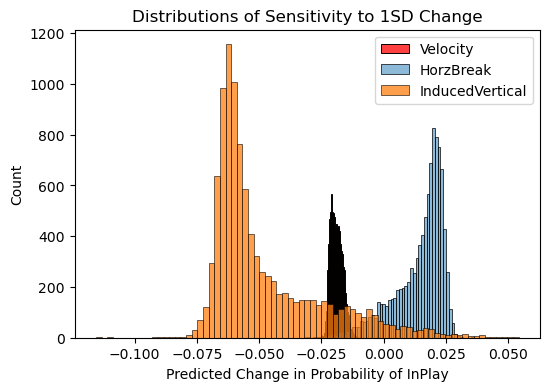

In [94]:
fig, ax = plt.subplots(figsize=(6,4))

sns.histplot(velo_sens['pred_sens'], label='Velocity', color='red')
sns.histplot(horz_sens['pred_sens'], label='HorzBreak', alpha=0.5)
sns.histplot(iv_sens['pred_sens'], label='InducedVertical')

plt.title("Distributions of Sensitivity to 1SD Change")
plt.xlabel("Predicted Change in Probability of InPlay")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

To interpret the above, if the pitcher increased his velocity 2.68mph for  
every pitch in the dataset, that's the distribution of how much the  
probability of InPlay would change.  

Naively, the largest possible change is from increasing InducedVertical. 
Increasing HorzBreak in the positive direction will marginally increase  
InPlay probability against Right handed batters if no other properties  
of the pitch changed.

# Double Machine Learning Test  

In [188]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [189]:
target = 'InPlay'
treatment = 'Velo'
context = ['HorzBreak', 'InducedVertBreak']

treatment_model = lgb.LGBMRegressor(max_depth=2)
target_model = lgb.LGBMClassifier(max_depth=2)

dbl_ml_splitter = KFold(n_splits=6)

treatment_pred = (
    cross_val_predict(treatment_model,
                      train_df[context],
                      train_df[treatment],
                      cv=dbl_ml_splitter)
)

target_pred = (
    cross_val_predict(target_model,
                      train_df[context],
                      train_df[target],
                      method="predict_proba",
                      cv=dbl_ml_splitter)[:,1]
)

treatment_residuals = train_df[treatment] - treatment_pred
target_residuals = train_df[target] - target_pred

In [191]:
treatment_residuals = train_df[treatment] - treatment_pred
target_residuals = train_df[target] - target_pred

residual_df = (
    pd.DataFrame({'treatment_res' : treatment_residuals,
                  'target_res' : target_residuals})
)

X = residual_df['treatment_res']
X = sm.add_constant(X) 
y = residual_df['target_res']

causal_model = sm.OLS(y, X)
causal_result = causal_model.fit()

causal_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             target_res   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     17.89
Date:                Mon, 04 Sep 2023   Prob (F-statistic):           2.36e-05
Time:                        10:51:44   Log-Likelihood:                -6035.0
No. Observations:               10000   AIC:                         1.207e+04
Df Residuals:                    9998   BIC:                         1.209e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.257e-05      0.004      0.019      0.985      -0.009       0.009
treatment_res    -0.0071      0.002     -4.230      0.000      -0.010      -0.004
==============================================================================
Omnibus:                     2664.929   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2012.821
Skew:                           0.999   Prob(JB):                         0.00
Kurtosis:                       2.084   Cond. No.                         2.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [194]:
treatment_residuals.max() * -0.0071

-0.057294434172269315

# Creating Predictive Model  

In [115]:
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

from sklearn.linear_model import LogisticRegression

In [102]:
# establishing a baseline that we have to beat
baseline_pred = [train_df['InPlay'].mean()] * len(train_df)

baseline_log_loss = log_loss(train_df['InPlay'], baseline_pred)
baseline_roc_auc_score = roc_auc_score(train_df['InPlay'], baseline_pred)

print("if we predicted the baseline probability for every pitch our log loss would be:", baseline_log_loss)
print("if we predicted the baseline probability for every pitch our area under the curve would be:", baseline_roc_auc_score)

if we predicted the baseline probability for every pitch our log loss would be: 0.5849423768611367
if we predicted the baseline probability for every pitch our area under the curve would be: 0.5


In [105]:
# defining the X and y that will be used to 
# train multiple models using stratifiedkfold
feature_cols = ['Velo', 'SpinRate', 'HorzBreak', 'InducedVertBreak']

X = train_df[feature_cols].copy()
y = train_df['InPlay']


# defining a stratifiedkfold split to ensure each fold
# has the same proportion of InPlay 1s
splitter = StratifiedKFold(n_splits=12, shuffle=True)

# initializing an array to store the out of fold predictions
oof_preds = np.zeros(len(train_df))
lgb_oof_preds = np.zeros(len(train_df))

for train, val in splitter.split(X, y):
    
    train_x = X.iloc[train]
    train_y = y[train]
    
    val_x = X.iloc[val]
    val_y = y[val]
    
    for_smf = pd.concat([train_x, train_y], axis=1)
    
    interaction_model = smf.logit('InPlay ~ standardize(Velo) + standardize(HorzBreak) + \
                           standardize(InducedVertBreak) + I(standardize(InducedVertBreak)**2) + \
                           standardize(HorzBreak):standardize(InducedVertBreak)',
                          data=for_smf)

    interaction_result = interaction_model.fit()
    
    
    lgb_model = lgb.LGBMClassifier(max_depth=2)    
    lgb_model.fit(train_x, train_y)
    
    statsmod_preds = interaction_result.predict(val_x)
    lgb_preds = lgb_model.predict_proba(val_x)[:, 1]

    oof_preds[val] = statsmod_preds
    lgb_oof_preds[val] = lgb_preds

Optimization terminated successfully.
         Current function value: 0.578137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578128
  

In [106]:
linear_log_loss_oof = log_loss(y, oof_preds)
linear_roc_auc_score = roc_auc_score(y, oof_preds)

gbt_log_loss_oof = log_loss(y, lgb_oof_preds)
gbt_roc_auc_score = roc_auc_score(y, lgb_oof_preds)

model_perf = (
    pd.DataFrame({
        'baseline_logloss' : baseline_log_loss, 
        'baseline_rocscore' : baseline_roc_auc_score,
        'sklinear_logloss' : linear_log_loss_oof,
        'gbt_logloss' : gbt_log_loss_oof,
        'sklinear_rocscore' : linear_roc_auc_score,
        'gbt_rocscore': gbt_roc_auc_score}, index=[0])
)

model_perf

,baseline_logloss,baseline_rocscore,sklinear_logloss,gbt_logloss,sklinear_rocscore,gbt_rocscore
0,0.584942,0.5,0.578835,0.57997,0.571561,0.563798


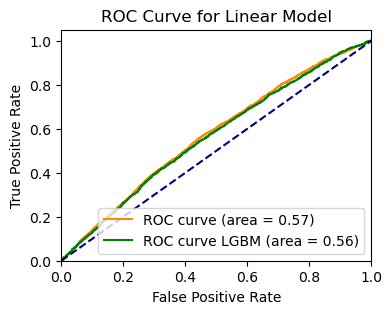

In [111]:
# get the roc curve
fpr, tpr, thresholds = roc_curve(y, oof_preds)
sm_fpr, sm_tpr, thresholds = roc_curve(y, lgb_oof_preds)

plt.figure(figsize=(4, 3))

plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {linear_roc_auc_score:.2f})')
plt.plot(sm_fpr, sm_tpr, color='green', label=f'ROC curve LGBM (area = {gbt_roc_auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve for Linear Model')

plt.legend(loc="lower right")
plt.show()

In [116]:
# for the sake of the model predictions, i'm going to train a model
# on the entire set of out of fold predictions, including the gbt

meta_model_X = np.column_stack((oof_preds, lgb_oof_preds)).copy()
meta_model_y = y

meta_model = LogisticRegression()

meta_model.fit(meta_model_X, meta_model_y)

LogisticRegression()

In [117]:
meta_model.coef_

array([[2.689209  , 1.72219284]])

In [125]:
# training an lgbm on the entire dataset
lgbm_model_all = lgb.LGBMClassifier(max_depth=2)
lgbm_model_all.fit(X, y)

LGBMClassifier(max_depth=2)

In [126]:
deploy_df = pd.read_csv('deploy.csv')

deploy_df.head()

,Velo,SpinRate,HorzBreak,InducedVertBreak
0,94.72,2375.0,3.10,18.15
1,95.25,2033.0,11.26,14.50
2,92.61,2389.0,11.00,21.93
3,94.94,2360.0,6.84,18.11
4,97.42,2214.0,16.70,13.38


In [151]:
deploy_df.isnull().sum()

Velo                   0
SpinRate               0
HorzBreak              0
InducedVertBreak       0
LogInducedVertBreak    0
InPlay                 0
preds                  0
dtype: int64

In [128]:
deploy_df['SpinRate'] = deploy_df['SpinRate'].fillna(train_df['SpinRate'].median())

In [145]:
# getting lgbm preds
lgbm_preds = lgbm_model_all.predict_proba(deploy_df[feature_cols])[:,1]

# since deploy has a slightly diff structure, gotta fiddle around with it
missing_cols = set(train_df.columns) - set(deploy_df.columns)
for col in missing_cols:
    deploy_df[col] = 0

logit_predictions = interaction_result.predict(deploy_df)

In [147]:
final_data = np.column_stack((logit_predictions, lgbm_preds))
final_preds = meta_model.predict_proba(final_data)[:,1]

In [148]:
deploy_df['preds'] = final_preds

In [150]:
deploy_df['preds'].to_csv('predictions.csv')